INFO:__main__:Loading val dataset
INFO:__main__:Number of validation examples 400
INFO:__main__:Loaded model weights from: /home/ubuntu/caitongbo/COVID-Efficientnet-Pytorch/experiments/ckpts/vit_csra_base_16/vit_csra_base_16_Acc_97.25_F1_96.70_pre_96.62_rec_97.00_step_16400.pth


/home/ubuntu/caitongbo/COVID-Efficientnet-Pytorch/dataset/covidx9/train_COVIDx9A.txt
/home/ubuntu/caitongbo/COVID-Efficientnet-Pytorch/dataset/covidx9/test_COVIDx9A.txt


INFO:util:### Checkpoint weights that WILL be loaded: ###
INFO:util:vit.blocks.3.attn.proj.weight
INFO:util:vit.blocks.1.mlp.fc2.weight
INFO:util:vit.blocks.5.mlp.fc2.weight
INFO:util:vit.blocks.8.attn.qkv.bias
INFO:util:vit.blocks.7.norm2.bias
INFO:util:vit.blocks.7.norm2.weight
INFO:util:vit.blocks.4.mlp.fc1.weight
INFO:util:vit.blocks.1.attn.qkv.weight
INFO:util:vit.blocks.6.norm2.weight
INFO:util:vit.cls_token
INFO:util:vit.blocks.1.norm2.weight
INFO:util:vit.blocks.7.attn.qkv.weight
INFO:util:vit.blocks.2.norm1.weight
INFO:util:vit.blocks.5.attn.proj.bias
INFO:util:vit.blocks.3.mlp.fc2.bias
INFO:util:vit.blocks.4.mlp.fc2.weight
INFO:util:vit.blocks.3.attn.proj.bias
INFO:util:vit.blocks.8.attn.proj.bias
INFO:util:vit.blocks.0.mlp.fc1.bias
INFO:util:vit.blocks.3.mlp.fc1.weight
INFO:util:vit.blocks.11.norm1.weight
INFO:util:vit.blocks.11.attn.qkv.weight
INFO:util:vit.blocks.10.attn.proj.bias
INFO:util:vit.blocks.10.norm2.bias
INFO:util:vit.blocks.1.norm2.bias
INFO:util:vit.blocks.10.

0.9725 0.9670142762926268 0.9661508704061896 0.9700000000000001
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       100
           1       0.99      0.93      0.96       100
           2       1.00      0.98      0.99       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]] [[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


/home/ubuntu/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


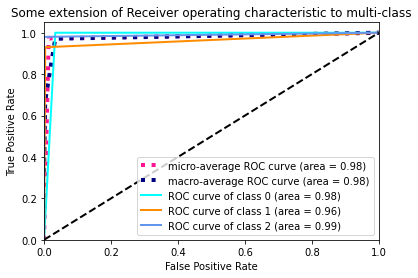

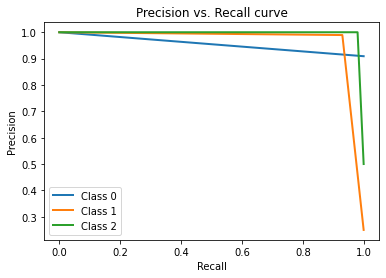

INFO:__main__:VALIDATION | Accuracy 0.9725 | F1 0.9670 | Precision 0.9662 | Recall 0.9700
INFO:__main__:Validation end


           Normal  Pneumonia  COVID-19
Normal        100          0         0
Pneumonia       7         93         0
COVID-19        3          1       196


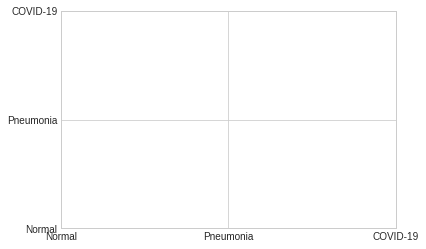

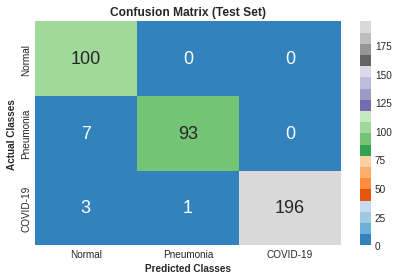

0

In [1]:
"""
Minimal prediction example
"""

import torch
from PIL import Image

from model.architecture import COVIDNext50
# from data.transforms import val_transforms
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

import config
import os
import util
import numpy as np

import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.dataset import COVIDxFolder
from data import transforms
from torch.utils.data import DataLoader
from model import architecture

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = config.random_seed
if seed:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

if config.gpu and not torch.cuda.is_available():
    raise ValueError("GPU not supported or enabled on this system.")
use_gpu = config.gpu

rev_mapping = {idx: name for name, idx in config.mapping.items()}

model = COVIDNext50(n_classes=len(rev_mapping)).to(device)


def get_roc_auc(trues, preds):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  print(trues, preds)
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(nb_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  lw = 2
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.savefig("ROC_10分类.png")
  plt.show()

def get_pr(trues, preds):

    #roc
    # roc curve
    # fpr = dict()
    # tpr = dict()

    # for i in range(n_classes):
    #     fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
    #                                   y_score[:, i]))
    #     plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

    # plt.xlabel("false positive rate")
    # plt.ylabel("true positive rate")
    # plt.legend(loc="best")
    # plt.title("ROC curve")
    # plt.show()
    # precision recall curve
    labels = [0,1,2]
    n_classes = len(labels)
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(trues[:, i],
                                                            preds[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))
        
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision vs. Recall curve")
    plt.show()


def validate(train_loader,data_loader, model, best_score, global_step, cfg):
    global bestacc
    model.eval()
    gts, predictions = [], []

    ##test 
    gts, predictions = [], []
    log.info("Validation started...")
    for data in data_loader:
        imgs, labels = data
        imgs = util.to_device(imgs, gpu=cfg.gpu)

        with torch.no_grad():
            logits = model(imgs)
            probs = model.module.probability(logits)
            # print(probs)
            preds = torch.argmax(probs, dim=1).cpu().numpy()

        labels = labels.cpu().detach().numpy()

        predictions.extend(preds)
        gts.extend(labels)

    predictions = np.array(predictions, dtype=np.int32)
    gts = np.array(gts, dtype=np.int32)
    acc, f1, prec, rec = util.clf_metrics(predictions=predictions,
                                          targets=gts,
                                          average="macro")
    print(acc,f1,prec,rec)
    report = classification_report(gts, predictions)
    print(report)

    test_trues = label_binarize(gts, classes=[i for i in range(3)])
    test_preds = label_binarize(predictions, classes=[i for i in range(3)])
    get_roc_auc(test_trues, test_preds)

    get_pr(test_trues, test_preds)

    # exit()
    ConfusionMatrix_test = confusion_matrix(gts,predictions)
    exit()
    ConfusionMatrix_test = pd.DataFrame(ConfusionMatrix_test, index=['Normal','Pneumonia','COVID-19'], columns=['Normal','Pneumonia','COVID-19'])
    print(ConfusionMatrix_test)   # 混淆矩阵
    log.info("VALIDATION | Accuracy {:.4f} | F1 {:.4f} | Precision {:.4f} | "
             "Recall {:.4f}".format(acc, f1, prec, rec))
    # if acc > best_score:
    #     save_config = {
    #                 'name': config.name,
    #                 'save_dir': config.ckpts_dir,
    #                 'global_step': global_step,
    #                 'clf_report': report
    #             }
    #     bestacc = acc
    #     save_model(model=model, config=save_config)
    #     best_score = acc
    log.info("Validation end")

    # model.train()
    #绘制混淆矩阵
    plt.style.use('seaborn-whitegrid')
    classes=['Normal','Pneumonia','COVID-19']
    indices = np.array(range(len(classes)))

    plt.xticks(indices, classes)
    plt.yticks(indices, classes)   
    fig = plt.figure()

    # ax = fig.add_subplot(121)
    # ax = sns.heatmap(ConfusionMatrix_train, annot=True, cmap='tab20c',
    #                  fmt='d', annot_kws={'size': 18})
              
    # ax.set_title('Confusion Matrix (Train Set)', fontweight='bold')
    # ax.set_xlabel('Predicted Classes', fontweight='bold')
    # ax.set_ylabel('Actual Classes', fontweight='bold')

    ax = fig.add_subplot(111)
    ax = sns.heatmap(ConfusionMatrix_test, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Test Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'outputs/confusion_matrices/confusion_matrices.svg',format="svg")
    plt.show()
    plt.close()

    return best_score
    # return predictions

log.info("Loading val dataset")
train_dataset = COVIDxFolder(config.train_imgs, config.train_labels,
                                transforms.train_transforms(config.width,
                                                            config.height))
train_loader = DataLoader(train_dataset,
                          batch_size=config.batch_size,
                          shuffle=True,
                          drop_last=True,
                          num_workers=config.n_threads,
                          pin_memory=use_gpu)  

val_dataset = COVIDxFolder(config.val_imgs, config.val_labels,
                            transforms.val_transforms(config.width,
                                                        config.height))
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        num_workers=config.n_threads,
                        pin_memory=use_gpu)
log.info("Number of validation examples {}".format(len(val_dataset)))

if config.weights:
    state = torch.load(config.weights)
    # state = None
    log.info("Loaded model weights from: {}".format(config.weights))
else:
    state = None

state_dict = state["state_dict"] if state else None
model = architecture.COVIDNext50(n_classes=config.n_classes)
if state_dict:
    model = util.load_model_weights(model=model, state_dict=state_dict)

if use_gpu:
    model.cuda()
    model = torch.nn.DataParallel(model)

log.info("Number of validation examples {}".format(len(val_dataset)))
validate(train_loader,val_loader,model,best_score=0,global_step=0,cfg=config)

/home/ubuntu/caitongbo/COVID-Efficientnet-Pytorch/dataset/covidx9/train_cutmix.txt
/home/ubuntu/caitongbo/COVID-Efficientnet-Pytorch/dataset/covidx9/train_cutmix.txt
cutmix
tensor([0.8682, 0.1318, 0.0000])
tensor([0.0000, 0.7573, 0.2427])
tensor([0.4235, 0.0000, 0.5765])


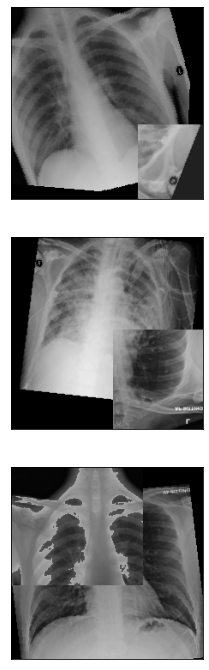

no cutmix
tensor(0)
tensor(1)
tensor(2)


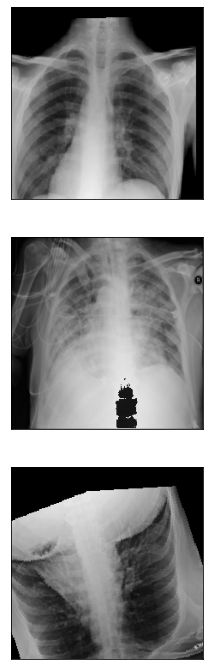

default
no cutmix
tensor(0)
tensor(1)
tensor(2)


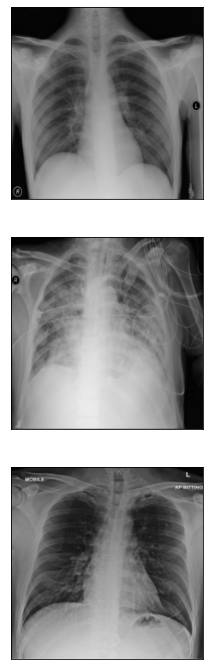

In [86]:
import matplotlib.pyplot as plt
from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss
from data.dataset import COVIDxFolder
import config
from data import transforms
import torch

if config.gpu and not torch.cuda.is_available():
    raise ValueError("GPU not supported or enabled on this system.")
use_gpu = config.gpu
def imageConvert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    return image


train_imgs = config.train_imgs
train_labels = config.train_labels_cutmix
batch_size = 3
train_dataset0 = COVIDxFolder(train_imgs, train_labels,
                                transforms.val_transforms(config.width,
                                                            config.height))
train_dataset = COVIDxFolder(train_imgs, train_labels,
                                transforms.train_transforms(config.width,
                                                            config.height))

train_loader0 = torch.utils.data.DataLoader(train_dataset0,
                          batch_size=batch_size,
                          shuffle=False,
                          drop_last=True,
                          num_workers=config.n_threads,
                          pin_memory=use_gpu)

train_loader1 = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          drop_last=True,
                          num_workers=config.n_threads,
                          pin_memory=use_gpu)

train_dataset = CutMix(train_dataset, num_class=3, beta=1.0, prob=0.5, num_mix=2)    # this is paper's original setting for cifar.

train_loader =torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            drop_last=True,
                                            num_workers=config.n_threads,
                                            pin_memory=use_gpu)
fig=plt.figure(figsize=(12, 12))
columns = 1
rows = 3

print("cutmix")
inputs, classes = iter(train_loader).next()
for index in range (columns*rows):
    ax = fig.add_subplot(rows, columns, index+1, xticks=[], yticks=[])
    # ax.set_xlabel(classes[index], fontweight='bold')
    print(classes[index])
    plt.imshow(imageConvert(inputs[index]))
plt.show()

fig=plt.figure(figsize=(12, 12))
columns = 1
rows = 3
print("no cutmix")
inputs, classes = iter(train_loader1).next()
for index in range (columns*rows):
    ax = fig.add_subplot(rows, columns, index+1, xticks=[], yticks=[])
    # ax.set_xlabel(classes[index], fontweight='bold')
    print(classes[index])
    plt.imshow(imageConvert(inputs[index]))
plt.show()

print("default")
fig=plt.figure(figsize=(12, 12))
columns = 1
rows = 3
print("no cutmix")
inputs, classes = iter(train_loader0).next()
for index in range (columns*rows):
    ax = fig.add_subplot(rows, columns, index+1, xticks=[], yticks=[])
    # ax.set_xlabel(classes[index], fontweight='bold')
    print(classes[index])
    plt.imshow(imageConvert(inputs[index]))
plt.show()

In [ ]:
"""
Minimal prediction example
"""
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, LayerCAM, score_cam
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
from torchvision.models import resnet50
import torch
from PIL import Image
import os
from model.architecture import COVIDNext50
from data.transforms import val_transforms
from model import architecture
import util
import logging

import config
import numpy as np
import cv2
rev_mapping = {idx: name for name, idx in config.mapping.items()}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if config.gpu and not torch.cuda.is_available():
    raise ValueError("GPU not supported or enabled on this system.")
use_gpu = config.gpu


#vit
def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                    height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# #swin
def reshape_transform_swin(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def main(net):
    log = logging.getLogger(__name__)
    logging.basicConfig(level=logging.INFO)
    if net=='resnet50':
        weight = config.weights[1]
    if net == 'resnet_csra':
        weight = config.weights[2]
    if net == 'resnet_csra_fpn':
        weight = config.weights[3]
    if net == 'vit':
        weight = config.weights[3]
    if net == 'vit_csra':
        weight = config.weights[4]
    if net == 'swin':
        weight = config.weights[5]
    if net == 'swin_csra':
        weight = config.weights[6]

    if weight:
        state = torch.load(weight)
        # state = None
        log.info("Loaded model weights from: {}".format(weight))
    else:
        state = None

    state_dict = state["state_dict"] if state else None
    model = architecture.COVIDNext50(net,n_classes=config.n_classes,)
    if state_dict:
        model = util.load_model_weights(model=model, state_dict=state_dict)

    if use_gpu:
        model.cuda()
        # model = torch.nn.DataParallel(model)

    transforms = val_transforms(width=config.width, height=config.height)


    gradacam = False
    gradcammplusplus=False
    layercam = True
    scorecam = False

    pth = config.sample

    i=0
    while(i<3):
        if i==0:
            imgs =os.listdir(pth+'normal/')
            imgs_pth = pth+'normal/'
        elif i==1:
            imgs =os.listdir(pth+'pneumonia/')
            
            imgs_pth = pth+'pneumonia/'
        elif i==2:
            imgs =os.listdir(pth+'COVID-19/')
            imgs_pth = pth+'COVID-19/'

        for img_name in imgs:
            img_pth = imgs_pth+img_name
            print(img_pth)
            img = Image.open(img_pth).convert("RGB")
            # img = np.float32(img) / 255
            img_tensor = transforms(img).unsqueeze(0)
            img = img.resize((224,224))
            img = np.float32(img) / 255
            # rgb_img = cv2.imread(img_pth, 1)[:, :, ::-1]
            # rgb_img = cv2.resize(rgb_img, (224, 224))
            # rgb_img = np.float32(rgb_img) / 255
            # img_tensor = preprocess_image(img,mean=[0.5,0.5,0.5],std=[0.5, 0.5, 0.5])

            img_tensor = util.to_device(img_tensor, gpu=config.gpu)
            with torch.no_grad():
                logits = model(img_tensor)
                cat_id = int(torch.argmax(logits))
            print("Prediction for {} is: {},{}".format(img_pth, rev_mapping[cat_id],cat_id))

            if net =='resnet50':
                target_layers = [model.resnet.layer4[-1]] #resnet
            elif net == 'resnet_csra' or net=='resnet_csra_fpn':
                target_layers = [model.resnet_csra.layer4[-1]] #resnet_csra
            elif net == 'vit' or net == 'vit_csra':
                target_layers = [model.vit.blocks[-1].norm1] #vit
            elif net == 'swin' or net == 'swin_csra':
                target_layers = [model.model.layers[-1].blocks[-1].norm2] #swin


            # Construct the CAM object once, and then re-use it on many images:
            if gradacam==True:
                cam = GradCAM(model=model, target_layers=target_layers, use_cuda=config.gpu)  
                # cam = GradCAM(model=model, target_layers=target_layers, use_cuda=config.gpu,reshape_transform=reshape_transform)  
                cam_type = 'gradcam'
            elif gradcammplusplus==True:
                cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=config.gpu)
                cam_type = 'gradcamplusplus'
            elif scorecam==True:
                cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=config.gpu)
                cam_type = 'scorecam'
            elif layercam==True:
                if net == 'swin' or net == 'swin_csra':
                    cam = LayerCAM(model=model, target_layers=target_layers, use_cuda=config.gpu,reshape_transform=reshape_transform_swin)  
                elif net == 'vit' or net == 'vit_csra':
                    cam = LayerCAM(model=model, target_layers=target_layers, use_cuda=config.gpu,reshape_transform=reshape_transform_vit)  
                # cam = LayerCAM(model=model, target_layers=target_layers, use_cuda=config.gpu)
                else:
                    cam = LayerCAM(model=model, target_layers=target_layers, use_cuda=config.gpu)  
                cam_type = 'layercam'

            # You can also use it within a with statement, to make sure it is freed,
            # In case you need to re-create it inside an outer loop:
            # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
            #   ...

            # If target_category is None, the highest scoring category
            # will be used for every image in the batch.
            # target_category can also be an integer, or a list of different integers
            # for every image in the batch.
            target_category = None
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            # grayscale_cam = cam(input_tensor=img_tensor, target_category=target_category,aug_smooth=True,eigen_smooth=True)
            grayscale_cam = cam(input_tensor=img_tensor, targets=target_category)


            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
            cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
            # plt.show(cam_image.all())
            class_path = './results/'+net+'/'+cam_type
            if 'normal' in imgs_pth:
                img_path = class_path +'/Normal/'
                if not os.path.exists(img_path):
                    os.makedirs(img_path)
                img_save =img_path+rev_mapping[cat_id]+'_'+img_name
            if 'COVID-19' in imgs_pth:
                img_path = class_path +'/COVID-19/'
                if not os.path.exists(img_path):
                    os.makedirs(img_path)
                img_save =img_path+rev_mapping[cat_id]+'_'+img_name
            if 'pneumonia' in imgs_pth:
                img_path = class_path +'/Pneumonia/'
                if not os.path.exists(img_path):
                    os.makedirs(img_path)
                img_save =img_path+rev_mapping[cat_id]+'_'+img_name
            cv2.imwrite(img_save, cam_image)
        i=i+1
if __name__ == '__main__':
    seed = config.random_seed
    if seed:
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    if config.gpu and not torch.cuda.is_available():
        raise ValueError("GPU not supported or enabled on this system.")
    use_gpu = config.gpu
    
    main(net = 'resnet50')
    # main(net = 'resnet_csra')
    # main(net = 'resnet_csra_fpn')
    # main(net = 'vit')
    # main(net = 'vit_csra')
    # main(net = 'swin')
    # main(net = 'swin_csra')

